# Capstone Project - The Battle of Neighborhoods (Week 1)

## Business Problem section

### Background

This project researches the optimazation of Chinese resturants in New York. Different branches of Chinese food have arrived in the U.S more than 150 years old firstly with the railway workers and early migrations, it has been popular ever since. 


### Data

The project extracts aforementioned N.Y.C neighborhoods data containing their Geolocations from https://cocl.us/new_york_dataset for its accessbility.
N.Y.C neighborhood boundaries aquires from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm. 
Other relavent data comes from FourSquare API and Libraries in Python.

### Methodology

- The project collects from https://cocl.us/new_york_dataset then processes into a dataframe.

- The project suppliments its dataframe by using FourSquare, within its call limits, to locate and filter venues and its rating, tips and likes generated from users.

- Data will be sorted based on rankings

- Finally, the project visuliazes the sorted data.

### Objectives

- What is the best upcoming location for a Chinese restaurant in NYC?
- Amongst different options, which Neighborhood will optimaze the chance to have a successful restaurant?

In [4]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
!pip -q install folium

import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
!pip install seaborn as sns

print('Import done!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

     |████████████████████████████████| 215 kB 4.3 MB/s eta 0:00:01
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2661 sha256=88287fa0a91d2574419ec9703eb787473d690d3434e3e5889d096c497bf8d075
  Stored in directory: /home/jovyan/.cache/pip/wheels/91/7f/88/5d7e4dd91a12f7bb860a61699096a9696076bf93a9fe2b1132
Successfully built sns
Import done!


connecting with FourSquare

In [45]:
CLIENT_ID = 'TX1FCNW4P4O24R0D1MMUYB4434YFA1JIDUQOUFDFI0R5MEZF' # your Foursquare ID
CLIENT_SECRET = 'BKJMWT4KCQRWFR0G0EWIDLBP0Q5AKCHBACEAAJMLEFFRMGHF' # your Foursquare Secret
VERSION = '20200609'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TX1FCNW4P4O24R0D1MMUYB4434YFA1JIDUQOUFDFI0R5MEZF
CLIENT_SECRET:BKJMWT4KCQRWFR0G0EWIDLBP0Q5AKCHBACEAAJMLEFFRMGHF


### Let us import the csv data

In [46]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [47]:
nyc_data = get_new_york_data()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Extracts the number of record shops in different Borough in NYC

In [48]:
nyc_data.shape

(306, 4)

### extracting the numbers of registered Chinese restaurants from FourSquare

In [49]:
chn_rest_ny = pd.read_csv('chn_rest_ny_tocsv1.csv')
chn_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
167,167,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
168,168,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
169,169,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
170,170,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
171,171,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [50]:
chn_rest_ny.shape

(172, 5)

### we discover which borough in NYC has the most Chinese resturants given the limited calls from Foursquare.

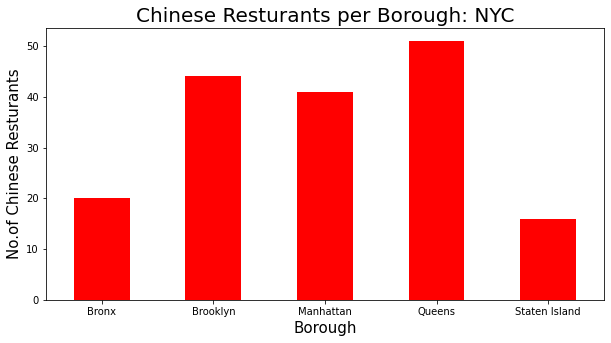

In [51]:

chn_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='red')
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

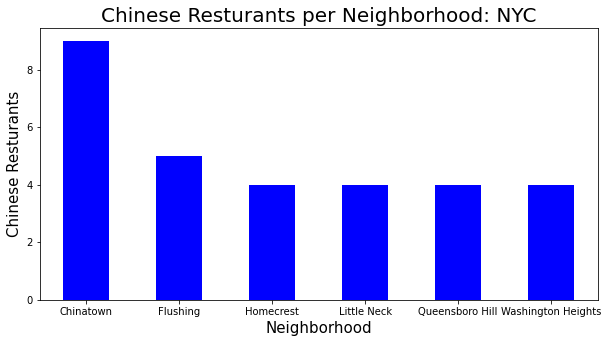

In [52]:
NOofNeigh = 6
chn_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='blue')
plt.title('Chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### so since Chinatown is a tradtional collective community for Chinese immigrants, it has the hightest amount of restaurants, let us take a look what has foursquare offered to us

In [53]:
chn_rest_ny[chn_rest_ny['Neighborhood']=='Chinatown']

,Unnamed: 0,Borough,Neighborhood,ID,Name
48,48,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
49,49,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
50,50,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
51,51,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
52,52,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
53,53,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
54,54,Manhattan,Chinatown,49ff2ae8f964a520e66f1fe3,Famous Sichuan
55,55,Manhattan,Chinatown,4c7ab2ac2d3ba143bb1d92d0,Sun's Organic Tea Shop
56,56,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant


### But according to the histgram above, Queens has the highest number in total

In [54]:
chn_rest_ny[chn_rest_ny['Borough']=='Queens']

,Unnamed: 0,Borough,Neighborhood,ID,Name
87,87,Queens,Woodside,4ae1d8b2f964a520e78721e3,Peking BBQ Chicken
88,88,Queens,Elmhurst,56296f14498edb1ed77b64a3,Five Loaves and Two Fishes
89,89,Queens,Elmhurst,4eaf0752d3e30d448393b841,Lao Bei Fang
90,90,Queens,Howard Beach,4ba57b0af964a5205f0b39e3,Empire Buffet
91,91,Queens,Howard Beach,4bc8bd4f92b376b00f16523a,East Meets West
92,92,Queens,Corona,4e4d0d2fbd413c4cc66e416c,Panda Garden Chinese
93,93,Queens,Forest Hills,4b68c90ff964a520da8c2be3,Great Wall Chinese Restaurant
94,94,Queens,Kew Gardens,4c350ac6452620a1502b260f,New China Fresh
95,95,Queens,Kew Gardens,4c585bb82308be9ab3405b6c,Jade Chinese Restaurant
96,96,Queens,Flushing,59f123cb59c4232293755a63,Hot Space Flushing


### Let us see about ratings and Likes. etc

In [55]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chn_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for borough, neighborhood, n_id, name in zip(chn_rest_ny["Borough"], chn_rest_ny["Neighborhood"], chn_rest_ny["ID"], chn_rest_ny["Name"]):
    print(borough, neighborhood, n_id, name)
    try:
        venue_details=get_venue_details(n_id)
        print(venue_details)
        
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',n_id)
        print('invalid for venue id=',n_id)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chn_rest_ny),')','processed')
    chn_rest_stats_ny = chn_rest_stats_ny.append({'Borough': borough,
                                                'Neighborhood': neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chn_rest_stats_ny.tail()    

Bronx Eastchester 4dabc3dc93a04642f09ccabd Xing Lung Chinese Restaurant
{'meta': {'code': 200, 'requestId': '5edece0271c428001b65b0be'}, 'response': {'venue': {'id': '4dabc3dc93a04642f09ccabd', 'name': 'Xing Lung Chinese Restaurant', 'contact': {'phone': '7183241014', 'formattedPhone': '(718) 324-1014'}, 'location': {'address': '3828 B Dyre Ave', 'crossStreet': 'E 233 St', 'lat': 40.8887854684858, 'lng': -73.83122576835156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8887854684858, 'lng': -73.83122576835156}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3828 B Dyre Ave (E 233 St)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xing-lung-chinese-restaurant/4dabc3dc93a04642f09ccabd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5edece24882fc7001b33c7c7'}, 'response': {'venue': {'id': '4e4d0387bd413c4cc66dfd72', 'name': 'Hung Hing Chinese Restaurant', 'contact': {'phone': '7185625050', 'formattedPhone': '(718) 562-5050'}, 'location': {'address': '239 Bedford Park Blvd', 'lat': 40.871181206606806, 'lng': -73.88675855253665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871181206606806, 'lng': -73.88675855253665}, {'label': 'entrance', 'lat': 40.871189, 'lng': -73.886476}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hung-hing-chinese-restaurant/4e4d0387bd413c4cc66dfd72', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5edece24882fc7001b33c9f0'}, 'response': {'venue': {'id': '4df3e68688772e1f81559d14', 'name': 'Good Choice Chinese Restaurant', 'contact': {'phone': '7185858866', 'formattedPhone': '(718) 585-8866'}, 'location': {'address': '570 E 138th St', 'crossStreet': 'at St. Anns Ave.', 'lat': 40.806515999999995, 'lng': -73.917477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.806515999999995, 'lng': -73.917477}, {'label': 'entrance', 'lat': 40.806629, 'lng': -73.917397}], 'postalCode': '10454', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['570 E 138th St (at St. Anns Ave.)', 'Bronx, NY 10454', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-choice-chinese-restaurant/4df3e68688772e1f81559d14', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5edecf65be61c9001b63ac64'}, 'response': {'venue': {'id': '4b89b62df964a520ff4c32e3', 'name': 'Sabor Latino Seafood Restaurant', 'contact': {'phone': '7188220899', 'formattedPhone': '(718) 822-0899'}, 'location': {'address': '2161 Starling Ave', 'crossStreet': 'at Purdy St', 'lat': 40.83636550185743, 'lng': -73.85303360278897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83636550185743, 'lng': -73.85303360278897}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2161 Starling Ave (at Purdy St)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sabor-latino-seafood-restaurant/4b89b62df964a520ff4c32e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5edececd1835dd001b38b5b5'}, 'response': {'venue': {'id': '4ca4fda4d971b1f77da5f2e0', 'name': 'Golden Phoenix Chinese Restaurant', 'contact': {'phone': '7185488888', 'formattedPhone': '(718) 548-8888'}, 'location': {'address': '5646 Riverdale Ave', 'crossStreet': 'West 258th Street', 'lat': 40.90568876262962, 'lng': -73.90429772559949, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90568876262962, 'lng': -73.90429772559949}, {'label': 'entrance', 'lat': 40.905658, 'lng': -73.90424}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5646 Riverdale Ave (West 258th Street)', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-phoenix-chinese-restaurant/4ca4fda4d971b1f77da5f2e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.

{'meta': {'code': 200, 'requestId': '5edecda9963d29001bc6d414'}, 'response': {'venue': {'id': '4c102bf0ce640f471a8d3952', 'name': 'k & Q Chinese Food', 'contact': {}, 'location': {'address': '713 Burke Ave', 'lat': 40.87139631626672, 'lng': -73.86687442284126, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87139631626672, 'lng': -73.86687442284126}, {'label': 'entrance', 'lat': 40.871296, 'lng': -73.866747}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['713 Burke Ave', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/k--q-chinese-food/4c102bf0ce640f471a8d3952', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message

{'meta': {'code': 200, 'requestId': '5edece30b4b684001bad7267'}, 'response': {'venue': {'id': '4d9a695ee5fd6ea8e3096df5', 'name': 'Lucky House Chinese Restaurant', 'contact': {'phone': '7186817430', 'formattedPhone': '(718) 681-7430'}, 'location': {'address': '202 E 167th St', 'lat': 40.83393302779995, 'lng': -73.91667401417777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83393302779995, 'lng': -73.91667401417777}, {'label': 'entrance', 'lat': 40.833882, 'lng': -73.916574}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 E 167th St', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-house-chinese-restaurant/4d9a695ee5fd6ea8e3096df5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5edecda1660a9f001ba430ab'}, 'response': {'venue': {'id': '5553702c498ecb85f99d8f37', 'name': 'XIN', 'contact': {'phone': '3476626222', 'formattedPhone': '(347) 662-6222', 'twitter': 'xinbayridge'}, 'location': {'address': '8320 3rd Ave', 'lat': 40.62508203621133, 'lng': -74.0304936920825, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62508203621133, 'lng': -74.0304936920825}, {'label': 'entrance', 'lat': 40.625159, 'lng': -74.030522}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8320 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xin/5553702c498ecb85f99d8f37', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5edecf46216785001b5fcf91'}, 'response': {'venue': {'id': '550efe11498e5b02d83a5e54', 'name': 'Xin Bay Ridge', 'contact': {}, 'location': {'address': '8320 3rd Ave', 'crossStreet': '8th Street', 'lat': 40.62520028339387, 'lng': -74.03042823522566, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62520028339387, 'lng': -74.03042823522566}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8320 3rd Ave (8th Street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xin-bay-ridge/550efe11498e5b02d83a5e54', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency':

{'meta': {'code': 200, 'requestId': '5edecd99bae9a2001b290604'}, 'response': {'venue': {'id': '4c2169947e85c928b88aba21', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182592831', 'formattedPhone': '(718) 259-2831', 'twitter': 'pandaexpress'}, 'location': {'address': '7323 20th Ave', 'lat': 40.611388, 'lng': -73.99078399999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611388, 'lng': -73.99078399999999}], 'postalCode': '11204', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7323 20th Ave', 'Brooklyn, NY 11204', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4c2169947e85c928b88aba21', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'p

{'meta': {'code': 200, 'requestId': '5edece0a71c428001b65c526'}, 'response': {'venue': {'id': '4d91f9a1d7b1236a6e343c38', 'name': 'Golden chopsticks', 'contact': {'phone': '7183758340', 'formattedPhone': '(718) 375-8340'}, 'location': {'address': '1986-88 Ocean Ave', 'lat': 40.61322, 'lng': -73.95387, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61322, 'lng': -73.95387}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1986-88 Ocean Ave', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-chopsticks/4d91f9a1d7b1236a6e343c38', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$

{'meta': {'code': 200, 'requestId': '5edecf6cbe61c9001b63bb70'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5edecf569da7ee001befecc0'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5edecd9bbae9a2001b290d03'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5edecf0c47e0d6001bebabbc'}, 'response': {'venue': {'id': '4c60a7cede6920a15f9d9664', 'name': "Michael and Ping's", 'contact': {'phone': '7187880017', 'formattedPhone': '(718) 788-0017', 'facebook': '107321149195', 'facebookUsername': 'michaelandpings', 'facebookName': "Michael & Ping's - Modern Chinese Take-out"}, 'location': {'address': '437 3rd Ave', 'crossStreet': 'btwn 7th & 8th St.', 'lat': 40.67216239483681, 'lng': -73.99037941409061, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67216239483681, 'lng': -73.99037941409061}, {'label': 'entrance', 'lat': 40.67216, 'lng': -73.990273}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['437 3rd Ave (btwn 7th & 8th St.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michael-and-pings/4c60a7cede6920a15f9d9664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', '

{'meta': {'code': 200, 'requestId': '5edeceaf0a2972001b9afd7d'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '5edecefb78a484001b49caa2'}, 'response': {'venue': {'id': '4f326c1a19836c91c7d64648', 'name': 'Wo Hop Chinese Restaurant', 'contact': {'phone': '7182357955', 'formattedPhone': '(718) 235-7955'}, 'location': {'address': '3150 Fulton St', 'lat': 40.681668, 'lng': -73.878741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681668, 'lng': -73.878741}, {'label': 'entrance', 'lat': 40.681716, 'lng': -73.878621}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3150 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wo-hop-chinese-restaurant/4f326c1a19836c91c7d64648', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5edecf801187ee001b1221c5'}, 'response': {'venue': {'id': '4d4a03494509721eab1d2ab0', 'name': 'Welcome Seafood Restaurant', 'contact': {'phone': '7182655048', 'formattedPhone': '(718) 265-5048'}, 'location': {'address': '2050 86th St', 'crossStreet': 'Bay 25th & 26th St.', 'lat': 40.60239878030012, 'lng': -73.99904604649204, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60239878030012, 'lng': -73.99904604649204}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2050 86th St (Bay 25th & 26th St.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/welcome-seafood-restaurant/4d4a03494509721eab1d2ab0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5edeccd002a172001b8b215d'}, 'response': {'venue': {'id': '4a71ff01f964a52016da1fe3', 'name': 'Kum Kau', 'contact': {'phone': '7186381850', 'formattedPhone': '(718) 638-1850'}, 'location': {'address': '463 Myrtle Ave', 'crossStreet': 'btwn Washington Ave & Hall St', 'lat': 40.693373086368084, 'lng': -73.96675330374048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693373086368084, 'lng': -73.96675330374048}, {'label': 'entrance', 'lat': 40.693463, 'lng': -73.966722}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['463 Myrtle Ave (btwn Washington Ave & Hall St)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kum-kau/4a71ff01f964a52016da1fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5edece0f71c428001b65cf87'}, 'response': {'venue': {'id': '521bf3b711d2dce4f1b42195', 'name': 'Hardee', 'contact': {'phone': '3478897210', 'formattedPhone': '(347) 889-7210'}, 'location': {'address': '351 Myrtle Ave', 'crossStreet': 'Adelphi', 'lat': 40.69321363724748, 'lng': -73.97234219401466, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69321363724748, 'lng': -73.97234219401466}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['351 Myrtle Ave (Adelphi)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hardee/521bf3b711d2dce4f1b42195', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'htt

{'meta': {'code': 200, 'requestId': '5edeceefd03993001b0e5ed9'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 3, 'groups': [{'type': 'others', 'c

{'meta': {'code': 200, 'requestId': '5edecda0bae9a2001b2916eb'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5edecf2ac546f3001b27e2da'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5edecf3660ba08001b2365ee'}, 'response': {'venue': {'id': '58df00318cfe546addb99246', 'name': 'Birds of a Feather', 'contact': {'phone': '7189696800', 'formattedPhone': '(718) 969-6800', 'instagram': 'birdsofafeatherbk'}, 'location': {'address': '191 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71426224260337, 'lng': -73.96057226233967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71426224260337, 'lng': -73.96057226233967}, {'label': 'entrance', 'lat': 40.714297, 'lng': -73.960548}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['191 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birds-of-a-feather/58df00318cfe546addb99246', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix'

{'meta': {'code': 200, 'requestId': '5edecee10cc1fd001b806a4b'}, 'response': {'venue': {'id': '54b318a1498eb29e9541053a', 'name': 'Wei Williamsburg', 'contact': {'phone': '7183601908', 'formattedPhone': '(718) 360-1908', 'twitter': 'williamsburgwei'}, 'location': {'address': '145 Borinquen Pl', 'crossStreet': 'Keap Street', 'lat': 40.71067589705568, 'lng': -73.95403239442538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71067589705568, 'lng': -73.95403239442538}, {'label': 'entrance', 'lat': 40.710819, 'lng': -73.953903}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'South Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Borinquen Pl (Keap Street)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wei-williamsburg/54b318a1498eb29e9541053a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '5edecd4e29ce6a001bb2442d'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5edecf5d9da7ee001beffc82'}, 'response': {'venue': {'id': '4cb0fb23eb65b1f7c61871cd', 'name': 'Panda Garden', 'contact': {'phone': '7186801126', 'formattedPhone': '(718) 680-1126'}, 'location': {'address': '9708 3rd Ave', 'lat': 40.615772172484405, 'lng': -74.03427146686259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615772172484405, 'lng': -74.03427146686259}, {'label': 'entrance', 'lat': 40.615751, 'lng': -74.034365}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden/4cb0fb23eb65b1f7c61871cd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5eded0151a4b0a001b9d8748'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快飯店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A3%AF%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '5edece0d1d67cb002894257f'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '5edecf5b0de0d9001b2fc82b'}, 'response': {'venue': {'id': '59d828f0916bc1155fde2c04', 'name': 'Hwa Yuan', 'contact': {'phone': '2129666002', 'formattedPhone': '(212) 966-6002', 'instagram': 'hwa.yuan.nyc', 'facebook': '463197850727690', 'facebookUsername': 'HwaYuanNYC', 'facebookName': 'Hwa Yuan 華園'}, 'location': {'address': '42 E Broadway', 'lat': 40.713618266530226, 'lng': -73.99597818966741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713618266530226, 'lng': -73.99597818966741}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 E Broadway', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hwa-yuan/59d828f0916bc1155fde2c04', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', '

{'meta': {'code': 200, 'requestId': '5edeceffb1cac0001b9b0010'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5edecf0a1e152c001b52e618'}, 'response': {'venue': {'id': '3fd66200f964a520b1ea1ee3', 'name': 'Great N.Y. Noodletown', 'contact': {'phone': '2123490923', 'formattedPhone': '(212) 349-0923'}, 'location': {'address': '28 Bowery', 'crossStreet': 'btwn Pell & Bayard St', 'lat': 40.715039001656855, 'lng': -73.99694075378208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715039001656855, 'lng': -73.99694075378208}, {'label': 'entrance', 'lat': 40.714988, 'lng': -73.997055}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Bowery (btwn Pell & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-ny-noodletown/3fd66200f964a520b1ea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5edecf00b1cac0001b9b0144'}, 'response': {'venue': {'id': '49ff2ae8f964a520e66f1fe3', 'name': 'Famous Sichuan', 'contact': {'phone': '2122333888', 'formattedPhone': '(212) 233-3888', 'twitter': 'famoussichuan'}, 'location': {'address': '10 Pell St', 'crossStreet': 'btwn Mott & Bowery', 'lat': 40.71472232549957, 'lng': -73.99764134012933, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71472232549957, 'lng': -73.99764134012933}, {'label': 'entrance', 'lat': 40.714773, 'lng': -73.997639}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 Pell St (btwn Mott & Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/famous-sichuan/49ff2ae8f964a520e66f1fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5edece36882fc7001b33f31b'}, 'response': {'venue': {'id': '4c7ab2ac2d3ba143bb1d92d0', 'name': "Sun's Organic Tea Shop", 'contact': {'phone': '2125663260', 'formattedPhone': '(212) 566-3260'}, 'location': {'address': '79 Bayard St', 'crossStreet': 'btwn Mott & Mulberry St', 'lat': 40.715710273410835, 'lng': -73.99869779295813, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715710273410835, 'lng': -73.99869779295813}, {'label': 'entrance', 'lat': 40.715639, 'lng': -73.998724}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Bayard St (btwn Mott & Mulberry St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/suns-organic-tea-shop/4c7ab2ac2d3ba143bb1d92d0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/c

{'meta': {'code': 200, 'requestId': '5edece930f59680025011249'}, 'response': {'venue': {'id': '3fd66200f964a520ceea1ee3', 'name': 'Deluxe Green Bo Restaurant', 'contact': {'phone': '2126252359', 'formattedPhone': '(212) 625-2359', 'twitter': 'deluxegreenbo'}, 'location': {'address': '66 Bayard St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.715544918133155, 'lng': -73.99813747002635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715544918133155, 'lng': -73.99813747002635}, {'label': 'entrance', 'lat': 40.715543, 'lng': -73.998033}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66 Bayard St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deluxe-green-bo-restaurant/3fd66200f964a520ceea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '5edececa9388d7001b4e85b5'}, 'response': {'venue': {'id': '4b292f38f964a520939a24e3', 'name': 'Yang Garden', 'contact': {'phone': '2127810055', 'formattedPhone': '(212) 781-0055', 'twitter': 'yang187garden'}, 'location': {'address': '816 W 187th St', 'crossStreet': 'Pinehurst', 'lat': 40.85530896752232, 'lng': -73.93783226069496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85530896752232, 'lng': -73.93783226069496}, {'label': 'entrance', 'lat': 40.855266, 'lng': -73.937644}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['816 W 187th St (Pinehurst)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-garden/4b292f38f964a520939a24e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '5edecf55542890001b6fa02e'}, 'response': {'venue': {'id': '4b3fe94af964a520e2b125e3', 'name': 'No. 1 Chinese Restaurant', 'contact': {'phone': '2127403188', 'formattedPhone': '(212) 740-3188'}, 'location': {'address': '825 W 181st St', 'crossStreet': 'Pinehurst Avenue', 'lat': 40.85123671099152, 'lng': -73.93960586750859, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85123671099152, 'lng': -73.93960586750859}, {'label': 'entrance', 'lat': 40.851353, 'lng': -73.93946}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['825 W 181st St (Pinehurst Avenue)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/no-1-chinese-restaurant/4b3fe94af964a520e2b125e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5edecef969babe001beedd24'}, 'response': {'venue': {'id': '4aaed36bf964a520736320e3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '2127959379', 'formattedPhone': '(212) 795-9379', 'twitter': 'thegreatwallma'}, 'location': {'address': '800 W 181st St', 'crossStreet': 'at Fort Washington Ave', 'lat': 40.85085901713292, 'lng': -73.93834216873442, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85085901713292, 'lng': -73.93834216873442}, {'label': 'entrance', 'lat': 40.850859, 'lng': -73.938504}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 W 181st St (at Fort Washington Ave)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4aaed36bf964a520736320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '5edecfb077af03001b866d60'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5edece141d67cb00289435aa'}, 'response': {'venue': {'id': '4bf348fce5eba593c8711e90', 'name': 'Crispy Bamboo Village', 'contact': {'phone': '2126945391', 'formattedPhone': '(212) 694-5391'}, 'location': {'address': '2526 Frederick Douglass Blvd', 'crossStreet': '135th St', 'lat': 40.81627823973171, 'lng': -73.94693839905996, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81627823973171, 'lng': -73.94693839905996}, {'label': 'entrance', 'lat': 40.816152, 'lng': -73.946596}], 'postalCode': '10030', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2526 Frederick Douglass Blvd (135th St)', 'New York, NY 10030', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crispy-bamboo-village/4bf348fce5eba593c8711e90', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5edecf34edbcad0023f95683'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5edeceea0cc1fd001b808165'}, 'response': {'venue': {'id': '4b53bfb3f964a5202daa27e3', 'name': 'Charley Mom', 'contact': {'phone': '2124396363', 'formattedPhone': '(212) 439-6363'}, 'location': {'address': '1580 York Ave', 'crossStreet': '83rd St', 'lat': 40.77415432548356, 'lng': -73.9484857648048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77415432548356, 'lng': -73.9484857648048}, {'label': 'entrance', 'lat': 40.774075, 'lng': -73.948269}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1580 York Ave (83rd St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/charley-mom/4b53bfb3f964a5202daa27e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5edecf1b14a126001b89980d'}, 'response': {'venue': {'id': '4ea5be4af5b9efc002cccdea', 'name': 'Shanghai', 'contact': {'phone': '2122888067', 'formattedPhone': '(212) 288-8067'}, 'location': {'address': '1388 2nd Ave', 'crossStreet': 'btwn 71st & 72nd St', 'lat': 40.768334, 'lng': -73.958493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768334, 'lng': -73.958493}, {'label': 'entrance', 'lat': 40.768342, 'lng': -73.958499}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1388 2nd Ave (btwn 71st & 72nd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shanghai/4ea5be4af5b9efc002cccdea', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5edeceb1ed78b8001b85585a'}, 'response': {'venue': {'id': '56759406498ecd2d68a85eec', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.76566581236336, 'lng': -73.95745129061507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76566581236336, 'lng': -73.95745129061507}, {'label': 'entrance', 'lat': 40.76577, 'lng': -73.957687}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/56759406498ecd2d68a85eec', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 

{'meta': {'code': 200, 'requestId': '5edecf669da7ee001bf01275'}, 'response': {'venue': {'id': '5529bfd8498ec6ce692d8015', 'name': 'Han Dynasty', 'contact': {'phone': '2128589060', 'formattedPhone': '(212) 858-9060'}, 'location': {'address': '215 W 85th St', 'crossStreet': 'at Broadway', 'lat': 40.78761996790675, 'lng': -73.97635945297974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78761996790675, 'lng': -73.97635945297974}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['215 W 85th St (at Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/5529bfd8498ec6ce692d8015', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5edece990f59680025012293'}, 'response': {'venue': {'id': '5960214035d3fc3e620ea646', 'name': 'La Salle Dumpling Room', 'contact': {'phone': '2125862000', 'formattedPhone': '(212) 586-2000'}, 'location': {'address': '35 W End Ave', 'crossStreet': 'West 61st Street', 'lat': 40.77309192987002, 'lng': -73.98938355991226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77309192987002, 'lng': -73.98938355991226}, {'label': 'entrance', 'lat': 40.77319, 'lng': -73.98951}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35 W End Ave (West 61st Street)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-salle-dumpling-room/5960214035d3fc3e620ea646', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5edecdb5660a9f001ba45f88'}, 'response': {'venue': {'id': '4aed1141f964a52001cd21e3', 'name': 'Wok City', 'contact': {'phone': '2124969714', 'formattedPhone': '(212) 496-9714'}, 'location': {'address': '153 Amsterdam Ave', 'crossStreet': 'Btw 66th & 67th St', 'lat': 40.77523255727379, 'lng': -73.98409665398943, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77523255727379, 'lng': -73.98409665398943}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['153 Amsterdam Ave (Btw 66th & 67th St)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wok-city/4aed1141f964a52001cd21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5edecf9e47b43d0023d02b12'}, 'response': {'venue': {'id': '5e024619523cd2000769f67a', 'name': 'Xi’an Famous Foods', 'contact': {}, 'location': {'address': '37 W 43rd St', 'lat': 40.754969, 'lng': -73.982497, 'labeledLatLngs': [{'label': 'display', 'lat': 40.754969, 'lng': -73.982497}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['37 W 43rd St', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5e024619523cd2000769f67a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5edecebf0a2972001b9b24d6'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '5edecec29c6f59001b31bfc2'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '5edeced29388d7001b4e99ec'}, 'response': {'venue': {'id': '5b36566f666116002c6b265e', 'name': 'Junzi Kitchen', 'contact': {'phone': '6468640277', 'formattedPhone': '(646) 864-0277', 'twitter': 'junzikitchen', 'instagram': 'junzikitchen'}, 'location': {'address': '170 Bleecker St', 'crossStreet': 'at Sullivan St', 'lat': 40.72876711130392, 'lng': -74.00053543555785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72876711130392, 'lng': -74.00053543555785}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Bleecker St (at Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/junzi-kitchen/5b36566f666116002c6b265e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix'

{'meta': {'code': 200, 'requestId': '5eded05bdf2774001bccbd5f'}, 'response': {'venue': {'id': '5c831f04029a550039fcca38', 'name': 'Chinese Graffiti', 'contact': {}, 'location': {'address': '171 Avenue A', 'lat': 40.728282, 'lng': -73.981952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728282, 'lng': -73.981952}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Avenue A', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chinese-graffiti/5c831f04029a550039fcca38', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '5edeced39388d7001b4e9b78'}, 'response': {'venue': {'id': '5647ee82498e8bfc0ddef53d', 'name': 'Málà Project', 'contact': {'phone': '2123538880', 'formattedPhone': '(212) 353-8880', 'facebook': '555745937892894', 'facebookUsername': 'malaprojectnyc', 'facebookName': 'Málà Project'}, 'location': {'address': '122 1st Ave', 'crossStreet': 'btwn 7th St & St Marks Pl', 'lat': 40.727126, 'lng': -73.98545, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727126, 'lng': -73.98545}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['122 1st Ave (btwn 7th St & St Marks Pl)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m%C3%A1l%C3%A0-project/5647ee82498e8bfc0ddef53d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '5edececdfb34b5001b6d8bab'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5edecdb8660a9f001ba46737'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '5edecf0e78a484001b49f663'}, 'response': {'venue': {'id': '5237264111d27e8e90c10357', 'name': 'China Blue', 'contact': {'phone': '2124310111', 'formattedPhone': '(212) 431-0111', 'twitter': 'chinabluenyc', 'facebook': '573513369373565', 'facebookUsername': 'chinabluenyc', 'facebookName': 'China Blue'}, 'location': {'address': '135 Watts St', 'crossStreet': 'btwn Washington St & Greenwich St', 'lat': 40.724047064916626, 'lng': -74.01019614169627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724047064916626, 'lng': -74.01019614169627}, {'label': 'entrance', 'lat': 40.724052, 'lng': -74.009953}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['135 Watts St (btwn Washington St & Greenwich St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-blue/5237264111d27e8e90c10357', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese

{'meta': {'code': 200, 'requestId': '5edece0e98205d001b5531b5'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5edecf6a9da7ee001bf01cf5'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency':

{'meta': {'code': 200, 'requestId': '5edecdeb006dce001b07eed4'}, 'response': {'venue': {'id': '4e1df590b61c7cb34d9735a8', 'name': 'RedFarm', 'contact': {'phone': '2127929700', 'formattedPhone': '(212) 792-9700', 'twitter': 'redfarmnyc', 'facebook': '240346079333009', 'facebookUsername': 'RedFarmNYC', 'facebookName': 'RedFarm'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.7341944046942, 'lng': -74.00626846361915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341944046942, 'lng': -74.00626846361915}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/redfarm/4e1df590b61c7cb34d9735a8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5edece1b1d67cb00289445cb'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '5edecdeb006dce001b07f00a'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '5edecf243907e7001b0e1141'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '5edecedab9a389001b8f0ef1'}, 'response': {'venue': {'id': '4ba57b0af964a5205f0b39e3', 'name': 'Empire Buffet', 'contact': {'phone': '7183232888', 'formattedPhone': '(718) 323-2888'}, 'location': {'address': '16149 Crossbay Blvd', 'lat': 40.65448296385855, 'lng': -73.83834313171272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65448296385855, 'lng': -73.83834313171272}], 'postalCode': '11414', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16149 Crossbay Blvd', 'Jamaica, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-buffet/4ba57b0af964a5205f0b39e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'mes

{'meta': {'code': 200, 'requestId': '5edecf1478a484001b4a0517'}, 'response': {'venue': {'id': '4e4d0d2fbd413c4cc66e416c', 'name': 'Panda Garden Chinese', 'contact': {'phone': '7186998781', 'formattedPhone': '(718) 699-8781'}, 'location': {'address': '10898 Corona Ave', 'lat': 40.7416189122051, 'lng': -73.85425693517048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7416189122051, 'lng': -73.85425693517048}], 'postalCode': '11368', 'cc': 'US', 'city': 'Corona', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10898 Corona Ave', 'Corona, NY 11368', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden-chinese/4e4d0d2fbd413c4cc66e416c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 

{'meta': {'code': 200, 'requestId': '5edecf6e0de0d9001b2ff4d1'}, 'response': {'venue': {'id': '4c350ac6452620a1502b260f', 'name': 'New China Fresh', 'contact': {}, 'location': {'address': '119-24 Metropolitan Ave', 'crossStreet': '83rd St', 'lat': 40.705968055799076, 'lng': -73.83113436243129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705968055799076, 'lng': -73.83113436243129}], 'postalCode': '11415', 'cc': 'US', 'neighborhood': 'Kew Gardens', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-24 Metropolitan Ave (83rd St)', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-china-fresh/4c350ac6452620a1502b260f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5edecf2714a126001b89b38a'}, 'response': {'venue': {'id': '59f123cb59c4232293755a63', 'name': 'Hot Space Flushing', 'contact': {}, 'location': {'lat': 40.762475, 'lng': -73.832107, 'labeledLatLngs': [{'label': 'display', 'lat': 40.762475, 'lng': -73.832107}], 'postalCode': '11354', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hot-space-flushing/59f123cb59c4232293755a63', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'id': '80973372', 'firstN

{'meta': {'code': 200, 'requestId': '5edecea50f59680025013d22'}, 'response': {'venue': {'id': '4abfef82f964a520179320e3', 'name': 'New Imperial Palace 東湖', 'contact': {'phone': '7189393501', 'formattedPhone': '(718) 939-3501'}, 'location': {'address': '13613 37th Ave', 'crossStreet': 'at Main St.', 'lat': 40.76174430274193, 'lng': -73.83052763667311, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76174430274193, 'lng': -73.83052763667311}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13613 37th Ave (at Main St.)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-imperial-palace-%E6%9D%B1%E6%B9%96/4abfef82f964a520179320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5edecf13b1cac0001b9b2eff'}, 'response': {'venue': {'id': '4e76a7f1e4cd325437dc9a1b', 'name': 'Yang Ji Chon', 'contact': {'phone': '718410980', 'formattedPhone': '718410980'}, 'location': {'address': '35-14 Farrington St', 'crossStreet': 'Northern Blvd', 'lat': 40.763985, 'lng': -73.831498, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763985, 'lng': -73.831498}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35-14 Farrington St (Northern Blvd)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-ji-chon/4e76a7f1e4cd325437dc9a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '5edecf2c7828ae001b6d9dc0'}, 'response': {'venue': {'id': '4b4a7016f964a520a18726e3', 'name': 'Ten Full Chinese', 'contact': {'phone': '7183618838', 'formattedPhone': '(718) 361-8838'}, 'location': {'address': '3949 48th Ave', 'crossStreet': '40th St', 'lat': 40.74000627173716, 'lng': -73.9250860394811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74000627173716, 'lng': -73.9250860394811}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3949 48th Ave (40th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ten-full-chinese/4b4a7016f964a520a18726e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5edece24211536001b452cd1'}, 'response': {'venue': {'id': '4e611ef0b61cd78087fa37c7', 'name': 'Lucky', 'contact': {'phone': '7185072900', 'formattedPhone': '(718) 507-2900'}, 'location': {'address': '100-11 Astoria Blvd', 'lat': 40.76207354, 'lng': -73.868772, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76207354, 'lng': -73.868772}], 'postalCode': '11369', 'cc': 'US', 'city': 'East Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['100-11 Astoria Blvd', 'East Elmhurst, NY 11369', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky/4e611ef0b61cd78087fa37c7', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '5edecd65dd0f85001b54c777'}, 'response': {'venue': {'id': '4bafed40f964a520152c3ce3', 'name': 'Grand Sichuan', 'contact': {'phone': '7182688833', 'formattedPhone': '(718) 268-8833'}, 'location': {'address': '98-108 Queens Blvd', 'lat': 40.72702335142174, 'lng': -73.85478566841853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72702335142174, 'lng': -73.85478566841853}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-108 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-sichuan/4bafed40f964a520152c3ce3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5edecf5360ba08001b23aa63'}, 'response': {'venue': {'id': '4d8805b7d85f370481b0c9db', 'name': 'Little Pepper', 'contact': {'phone': '7189397788', 'formattedPhone': '(718) 939-7788'}, 'location': {'address': '18-24 College Point Blvd', 'crossStreet': 'btwn 18th & 20th Ave', 'lat': 40.78246231945881, 'lng': -73.84597571881392, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78246231945881, 'lng': -73.84597571881392}, {'label': 'entrance', 'lat': 40.782461, 'lng': -73.846003}], 'postalCode': '11356', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-24 College Point Blvd (btwn 18th & 20th Ave)', 'New York, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-pepper/4d8805b7d85f370481b0c9db', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5edecdd1963d29001bc731ca'}, 'response': {'venue': {'id': '4b78929ff964a520aad72ee3', 'name': 'Bell Garden', 'contact': {'phone': '6468134260', 'formattedPhone': '(646) 813-4260'}, 'location': {'address': '39-21 Bell Blvd', 'lat': 40.76464127677721, 'lng': -73.77154540261257, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76464127677721, 'lng': -73.77154540261257}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-21 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bell-garden/4b78929ff964a520aad72ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Chea

{'meta': {'code': 200, 'requestId': '5edecf799da7ee001bf03f88'}, 'response': {'venue': {'id': '53794fd211d282a3cce576a2', 'name': 'Little Dumpling 李小籠', 'contact': {'phone': '7182251178', 'formattedPhone': '(718) 225-1178', 'facebook': '470360493097830', 'facebookUsername': 'LittleDumpling.LittleNeck', 'facebookName': 'Little Dumpling 李小籠'}, 'location': {'address': '252-20 Northern Blvd', 'lat': 40.77024169789123, 'lng': -73.73578464440837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77024169789123, 'lng': -73.73578464440837}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-20 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling-%E6%9D%8E%E5%B0%8F%E7%B1%A0/53794fd211d282a3cce576a2', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5edecee49388d7001b4ec222'}, 'response': {'venue': {'id': '4bc25d5b4cdfc9b627109621', 'name': 'Northern Manor 同乐轩', 'contact': {'phone': '7182811500', 'formattedPhone': '(718) 281-1500'}, 'location': {'address': '25115 Northern Blvd', 'lat': 40.76933647282762, 'lng': -73.73674274681008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933647282762, 'lng': -73.73674274681008}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25115 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-manor-%E5%90%8C%E4%B9%90%E8%BD%A9/4bc25d5b4cdfc9b627109621', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5edecf67c8cff2001b874a8c'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

( 112 / 172 ) processed
Queens Bellerose 4df56327c65bf55ee53269c2 King Rice Chinese Restaurant
{'meta': {'code': 200, 'requestId': '5edecf6cc94979001b37d8d4'}, 'response': {'venue': {'id': '4df56327c65bf55ee53269c2', 'name': 'King Rice Chinese Restaurant', 'contact': {'phone': '5167752782', 'formattedPhone': '(516) 775-2782'}, 'location': {'address': '248-43 Jericho Tpke', 'lat': 40.72653316226951, 'lng': -73.71664486572116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72653316226951, 'lng': -73.71664486572116}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-43 Jericho Tpke', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-rice-chinese-restaurant/4df56327c65bf55ee53269c2', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

{'meta': {'code': 200, 'requestId': '5edecf806001fe001b5203ad'}, 'response': {'venue': {'id': '5aef90f3b9b37b002ceb20d4', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.703704, 'lng': -73.798936, 'labeledLatLngs': [{'label': 'display', 'lat': 40.703704, 'lng': -73.798936}], 'postalCode': '11432', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/5aef90f3b9b37b002ceb20d4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}}], '

{'meta': {'code': 200, 'requestId': '5edeced30a2972001b9b521d'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

{'meta': {'code': 200, 'requestId': '5edecf816001fe001b5205cf'}, 'response': {'venue': {'id': '4e4e3d94bd4101d0d7a5b3ee', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182768282', 'formattedPhone': '(718) 276-8282'}, 'location': {'address': '19617 Linden Blvd', 'lat': 40.693559321613336, 'lng': -73.7555283081094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693559321613336, 'lng': -73.7555283081094}], 'postalCode': '11412', 'cc': 'US', 'city': 'Saint Albans', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19617 Linden Blvd', 'Saint Albans, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4e4e3d94bd4101d0d7a5b3ee', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0

Queens Steinway 4c16e7c274fb20a16ee95012 Dragon Gate
{'meta': {'code': 200, 'requestId': '5edece5bb4b684001badd651'}, 'response': {'venue': {'id': '4c16e7c274fb20a16ee95012', 'name': 'Dragon Gate', 'contact': {'phone': '7182780799', 'formattedPhone': '(718) 278-0799'}, 'location': {'address': '19-30 37th St', 'crossStreet': '20th Avenue', 'lat': 40.778482850524256, 'lng': -73.90244734828681, 'labeledLatLngs': [{'label': 'display', 'lat': 40.778482850524256, 'lng': -73.90244734828681}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19-30 37th St (20th Avenue)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dragon-gate/4c16e7c274fb20a16ee95012', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '5edeceecb9a389001b8f3713'}, 'response': {'venue': {'id': '4d69549ede28224b0ac241be', 'name': 'Xing Xing', 'contact': {'phone': '7184748038', 'formattedPhone': '(718) 474-8038'}, 'location': {'address': '97-12 Rockaway Beach Blvd', 'lat': 40.584806, 'lng': -73.819429, 'labeledLatLngs': [{'label': 'display', 'lat': 40.584806, 'lng': -73.819429}, {'label': 'entrance', 'lat': 40.584788, 'lng': -73.819345}], 'postalCode': '11693', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-12 Rockaway Beach Blvd', 'Rockaway Beach, NY 11693', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xing-xing/4d69549ede28224b0ac241be', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '5edece7ba2e538001b2fe204'}, 'response': {'venue': {'id': '4f844c6fe4b0059705cb042c', 'name': 'Lake Pavilion Restaurant', 'contact': {'phone': '7188866693', 'formattedPhone': '(718) 886-6693'}, 'location': {'address': '60-15 Main St', 'crossStreet': 'at Horace Harding Expressway', 'lat': 40.74262183933804, 'lng': -73.82497019158409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262183933804, 'lng': -73.82497019158409}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60-15 Main St (at Horace Harding Expressway)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lake-pavilion-restaurant/4f844c6fe4b0059705cb042c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5edecf373907e7001b0e3bac'}, 'response': {'venue': {'id': '4c56000b3e2220a163eb3ea5', 'name': '88 Canteen', 'contact': {}, 'location': {'address': '58-46 Main St', 'crossStreet': '59th Avenue', 'lat': 40.74394216997164, 'lng': -73.82586206505242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74394216997164, 'lng': -73.82586206505242}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58-46 Main St (59th Avenue)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-canteen/4c56000b3e2220a163eb3ea5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '5edecf94be61c9001b641a6b'}, 'response': {'venue': {'id': '4ae78dbff964a52056ac21e3', 'name': "Fatima's Halal Kitchen", 'contact': {'phone': '7182780080', 'formattedPhone': '(718) 278-0080'}, 'location': {'address': '2525 Broadway', 'crossStreet': 'at Crescent St', 'lat': 40.76307107742646, 'lng': -73.92753602003499, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76307107742646, 'lng': -73.92753602003499}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2525 Broadway (at Crescent St)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fatimas-halal-kitchen/4ae78dbff964a52056ac21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fal

{'meta': {'code': 200, 'requestId': '5edecf13d03993001b0eb3c5'}, 'response': {'venue': {'id': '5cbb548166f3cd002cce8aeb', 'name': 'Bund On Broadway', 'contact': {}, 'location': {'address': '25-08 Broadway', 'crossStreet': 'Crescent', 'lat': 40.763065000000005, 'lng': -73.928221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763065000000005, 'lng': -73.928221}, {'label': 'entrance', 'lat': 40.763164, 'lng': -73.928187}], 'postalCode': '11106', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25-08 Broadway (Crescent)', 'New York, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bund-on-broadway/5cbb548166f3cd002cce8aeb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Du

{'meta': {'code': 200, 'requestId': '5edecdbeaba297001b5a81ba'}, 'response': {'venue': {'id': '4f32043a19833175d60a05a4', 'name': 'Chieng Garden Kitchen', 'contact': {'phone': '7184428271', 'formattedPhone': '(718) 442-8271'}, 'location': {'address': '183 Broad St', 'lat': 40.624376, 'lng': -74.080989, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624376, 'lng': -74.080989}, {'label': 'entrance', 'lat': 40.624287, 'lng': -74.080939}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['183 Broad St', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chieng-garden-kitchen/4f32043a19833175d60a05a4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d573

Staten Island New Dorp 4c14210c7f7f2d7fae69e068 Crown Palace
{'meta': {'code': 200, 'requestId': '5edecee3fb34b5001b6dbf4a'}, 'response': {'venue': {'id': '4c14210c7f7f2d7fae69e068', 'name': 'Crown Palace', 'contact': {'phone': '7189796882', 'formattedPhone': '(718) 979-6882'}, 'location': {'address': '235 New Dorp Ln', 'lat': 40.572839920244384, 'lng': -74.11430191648847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.572839920244384, 'lng': -74.11430191648847}, {'label': 'entrance', 'lat': 40.57288, 'lng': -74.114046}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['235 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crown-palace/4c14210c7f7f2d7fae69e068', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '5eded073df2774001bccf4a0'}, 'response': {'venue': {'id': '4d8bc294bb88f04d0f659e3a', 'name': 'Islander Taste I', 'contact': {}, 'location': {'address': '654 Rossville Ave', 'crossStreet': 'Woodrow Rd.', 'lat': 40.54272652878382, 'lng': -74.20758604813165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54272652878382, 'lng': -74.20758604813165}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['654 Rossville Ave (Woodrow Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/islander-taste-i/4d8bc294bb88f04d0f659e3a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'me

{'meta': {'code': 200, 'requestId': '5edece1d95feaf001b6e659c'}, 'response': {'venue': {'id': '4af378def964a520f8ed21e3', 'name': 'Bo Bo Kitchen', 'contact': {'phone': '7184625363', 'formattedPhone': '(718) 462-5363'}, 'location': {'address': '1601 Cortelyou Rd', 'crossStreet': '16th St.', 'lat': 40.64169629675543, 'lng': -73.96339356897623, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64169629675543, 'lng': -73.96339356897623}, {'label': 'entrance', 'lat': 40.641787, 'lng': -73.963446}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1601 Cortelyou Rd (16th St.)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bo-bo-kitchen/4af378def964a520f8ed21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5edecd6edd0f85001b54dc7a'}, 'response': {'venue': {'id': '4cc61c46b2beb1f74faa264c', 'name': "Everybody's Kitchen", 'contact': {'phone': '7189878888', 'formattedPhone': '(718) 987-8888'}, 'location': {'address': '577 Midland Ave', 'lat': 40.572446, 'lng': -74.092683, 'labeledLatLngs': [{'label': 'display', 'lat': 40.572446, 'lng': -74.092683}, {'label': 'entrance', 'lat': 40.572452, 'lng': -74.092837}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['577 Midland Ave', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/everybodys-kitchen/4cc61c46b2beb1f74faa264c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats':

{'meta': {'code': 200, 'requestId': '5edece7fa2e538001b2feb24'}, 'response': {'venue': {'id': '5165e9fee4b08d4837e87f35', 'name': 'Empire East', 'contact': {}, 'location': {'lat': 40.611896, 'lng': -74.157533, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611896, 'lng': -74.157533}], 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Staten Island, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-east/5165e9fee4b08d4837e87f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'id': '7843595', 'firstName': 'Lizzie', 'lastName': 'B', '

{'meta': {'code': 200, 'requestId': '5edecdc7bae9a2001b2973fd'}, 'response': {'venue': {'id': '4bd36553caff95212bd4d4f0', 'name': 'Island Garden', 'contact': {'phone': '7184209333', 'formattedPhone': '(718) 420-9333'}, 'location': {'address': '1372 Bay St', 'lat': 40.610237, 'lng': -74.063558, 'labeledLatLngs': [{'label': 'display', 'lat': 40.610237, 'lng': -74.063558}, {'label': 'entrance', 'lat': 40.610261, 'lng': -74.063506}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1372 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/island-garden/4bd36553caff95212bd4d4f0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, '

{'meta': {'code': 200, 'requestId': '5edecf78542890001b6ff00a'}, 'response': {'venue': {'id': '4dc5dc957d8b14fb46366e20', 'name': 'Mr Rice', 'contact': {'phone': '7188160080', 'formattedPhone': '(718) 816-0080'}, 'location': {'address': '536 Port Richmond Ave', 'lat': 40.629915999999994, 'lng': -74.14057, 'labeledLatLngs': [{'label': 'display', 'lat': 40.629915999999994, 'lng': -74.14057}, {'label': 'entrance', 'lat': 40.629902, 'lng': -74.14048}], 'postalCode': '10302', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['536 Port Richmond Ave', 'Staten Island, NY 10302', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-rice/4dc5dc957d8b14fb46366e20', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '5edece5a882fc7001b344765'}, 'response': {'venue': {'id': '4e4ce4a1bd413c4cc66d03da', 'name': 'China Wok', 'contact': {'phone': '7182095999', 'formattedPhone': '(718) 209-5999'}, 'location': {'address': '5813 Avenue T', 'lat': 40.615496, 'lng': -73.91850500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615496, 'lng': -73.91850500000001}, {'label': 'entrance', 'lat': 40.615478, 'lng': -73.918387}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5813 Avenue T', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-wok/4e4ce4a1bd413c4cc66d03da', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0},

{'meta': {'code': 200, 'requestId': '5edece5b882fc7001b34488a'}, 'response': {'venue': {'id': '4d483fd056eab60cab1e4086', 'name': 'Mr. Kam', 'contact': {'phone': '7185317100', 'formattedPhone': '(718) 531-7100'}, 'location': {'address': '6342 Veterans Ave', 'lat': 40.619384000000004, 'lng': -73.91575999999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.619384000000004, 'lng': -73.91575999999999}, {'label': 'entrance', 'lat': 40.619525, 'lng': -73.915825}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6342 Veterans Ave', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-kam/4d483fd056eab60cab1e4086', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '5edecf54edbcad0023f9a02f'}, 'response': {'venue': {'id': '57b902d4498ea31e223ebd15', 'name': 'Dhanshiri Chinese', 'contact': {'phone': '7182750001', 'formattedPhone': '(718) 275-0001'}, 'location': {'address': '169-28 Hillside ave', 'lat': 40.710873, 'lng': -73.792076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710873, 'lng': -73.792076}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['169-28 Hillside ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dhanshiri-chinese/57b902d4498ea31e223ebd15', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currenc

{'meta': {'code': 200, 'requestId': '5edecf6060ba08001b23c7d8'}, 'response': {'venue': {'id': '4c892761bbec6dcbdedbd958', 'name': 'Chopsticks', 'contact': {'phone': '7182048119', 'formattedPhone': '(718) 204-8119'}, 'location': {'address': '77-18 21st Ave', 'crossStreet': '21th street', 'lat': 40.77003329426498, 'lng': -73.89337000868528, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77003329426498, 'lng': -73.89337000868528}], 'postalCode': '11370', 'cc': 'US', 'city': 'East Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['77-18 21st Ave (21th street)', 'East Elmhurst, NY 11370', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chopsticks/4c892761bbec6dcbdedbd958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '5edecee09c6f59001b320562'}, 'response': {'venue': {'id': '3fd66200f964a520adea1ee3', 'name': 'Mr. Chow', 'contact': {'phone': '2127519030', 'formattedPhone': '(212) 751-9030', 'twitter': 'mrchow'}, 'location': {'address': '324 E 57th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.758702868596544, 'lng': -73.96455191801327, 'labeledLatLngs': [{'label': 'display', 'lat': 40.758702868596544, 'lng': -73.96455191801327}, {'label': 'entrance', 'lat': 40.758762, 'lng': -73.964381}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['324 E 57th St (btwn 1st & 2nd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-chow/3fd66200f964a520adea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5edece5d882fc7001b344e9d'}, 'response': {'venue': {'id': '4bb91c86b35776b0e5a1c901', 'name': 'Golden Wok', 'contact': {'phone': '7183922333', 'formattedPhone': '(718) 392-2333'}, 'location': {'address': '42-18 43rd Ave', 'crossStreet': 'Btwn 42nd & 43rd St', 'lat': 40.745251205698786, 'lng': -73.92144996734304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745251205698786, 'lng': -73.92144996734304}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-18 43rd Ave (Btwn 42nd & 43rd St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-wok/4bb91c86b35776b0e5a1c901', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '5edeced2ed78b8001b85a5c8'}, 'response': {'venue': {'id': '4be75c8f2468c928fc720243', 'name': "Tack's Chinese Take Out", 'contact': {'phone': '7189839854', 'formattedPhone': '(718) 983-9854'}, 'location': {'address': '11 Holden Blvd #C', 'crossStreet': 'at Manor Rd.', 'lat': 40.604777568819046, 'lng': -74.12115963849878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.604777568819046, 'lng': -74.12115963849878}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11 Holden Blvd #C (at Manor Rd.)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tacks-chinese-take-out/4be75c8f2468c928fc720243', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5edecf3d14a126001b89e77c'}, 'response': {'venue': {'id': '4bff2b03daf9c9b6dce8f9ef', 'name': 'Peking Kitchen', 'contact': {'phone': '7189826735', 'formattedPhone': '(718) 982-6735'}, 'location': {'address': '308 Bradley Ave.', 'lat': 40.603764018886665, 'lng': -74.13151426274659, 'labeledLatLngs': [{'label': 'display', 'lat': 40.603764018886665, 'lng': -74.13151426274659}], 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['308 Bradley Ave.', 'Staten Island, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-kitchen/4bff2b03daf9c9b6dce8f9ef', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5edecf8c6001fe001b5221b9'}, 'response': {'venue': {'id': '4d28b924ebacb1f72efbf34f', 'name': 'Wing Hing Seafood Restaurant', 'contact': {'phone': '7189980360', 'formattedPhone': '(718) 998-0360', 'facebook': '781970171866583', 'facebookUsername': 'winghingbrooklyn', 'facebookName': 'Wing Hing Seafood Restaurant'}, 'location': {'address': '1217 Avenue U', 'crossStreet': 'Homecrest Ave.', 'lat': 40.59850944116727, 'lng': -73.95957022162729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59850944116727, 'lng': -73.95957022162729}, {'label': 'entrance', 'lat': 40.598596, 'lng': -73.959559}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1217 Avenue U (Homecrest Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wing-hing-seafood-restaurant/4d28b924ebacb1f72efbf34f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restau

{'meta': {'code': 200, 'requestId': '5edecfd777af03001b86c7a0'}, 'response': {'venue': {'id': '4c54639f72cf0f47cd247bd4', 'name': 'Winley', 'contact': {}, 'location': {'address': 'Avenue U', 'crossStreet': 'Homecrest Ave', 'lat': 40.59866593, 'lng': -73.95939632, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59866593, 'lng': -73.95939632}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Avenue U (Homecrest Ave)', 'Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/winley/4c54639f72cf0f47cd247bd4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': F

{'meta': {'code': 200, 'requestId': '5edecf2d78a484001b4a4086'}, 'response': {'venue': {'id': '4d965fd061a3a1cde4989a42', 'name': 'Lucky Star Chinese Restaurant', 'contact': {'phone': '7185480374', 'formattedPhone': '(718) 548-0374'}, 'location': {'address': '145 W Kingsbridge Rd', 'lat': 40.86964790014166, 'lng': -73.90350800952127, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86964790014166, 'lng': -73.90350800952127}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 W Kingsbridge Rd', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-star-chinese-restaurant/4d965fd061a3a1cde4989a42', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
167,Staten Island,Prince's Bay,0,0,0,0,0
168,Bronx,Allerton,0,0,0,0,0
169,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.4,5
170,Bronx,Kingsbridge Heights,0,0,0,0,0
171,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.7,7


In [56]:
chn_rest_stats_ny.to_csv('chn_rest_stats_ny_csv.csv') 

In [57]:
chn_rest_stats_ny.shape

(172, 7)

In [58]:
chn_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       172 non-null    object
 1   Neighborhood  172 non-null    object
 2   ID            172 non-null    object
 3   Name          172 non-null    object
 4   Likes         172 non-null    object
 5   Rating        172 non-null    object
 6   Tips          172 non-null    object
dtypes: object(7)
memory usage: 9.5+ KB


In [59]:
chn_rest_stats_ny['Likes']=chn_rest_stats_ny['Likes'].astype('float64')
chn_rest_stats_ny['Tips']=chn_rest_stats_ny['Tips'].astype('float64')
chn_rest_stats_ny['Rating']=chn_rest_stats_ny['Rating'].astype('float64')
chn_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       172 non-null    object 
 1   Neighborhood  172 non-null    object 
 2   ID            172 non-null    object 
 3   Name          172 non-null    object 
 4   Likes         172 non-null    float64
 5   Rating        172 non-null    float64
 6   Tips          172 non-null    float64
dtypes: float64(3), object(4)
memory usage: 9.5+ KB


In [60]:
chn_rest_stats_ny.describe()

,Likes,Rating,Tips
count,172.000000,172.000000,172.000000
mean,55.017442,4.553488,19.825581
std,170.696457,3.671439,58.155105
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,6.500000,3.500000
75%,20.250000,7.700000,10.000000
max,1488.000000,9.200000,521.000000


In [61]:
# Resturant with most likes
chn_rest_stats_ny.iloc[chn_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 75, dtype: object

In [62]:
# most tips
chn_rest_stats_ny.iloc[chn_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 75, dtype: object

In [63]:
# the higest rating
chn_rest_stats_ny.iloc[chn_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                               9.2
Tips                                  10
Name: 80, dtype: object

In [64]:
#sorting them in to a table
ny_neighborhood_stats=chn_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
71,North Side,8.90
14,Chelsea,8.80
66,Murray Hill,8.80
102,West Village,8.70
63,Midtown South,8.70
99,Upper West Side,8.60
97,Tribeca,8.50
42,Greenwich Village,8.45
55,Lower East Side,8.45
28,East Village,8.40


In [65]:
## due to the limited call from Foursqure, this is the data at this moment.
ny_borough_stats=chn_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.882927
3,Queens,4.084314
1,Brooklyn,4.050000
0,Bronx,2.335000
4,Staten Island,1.675000


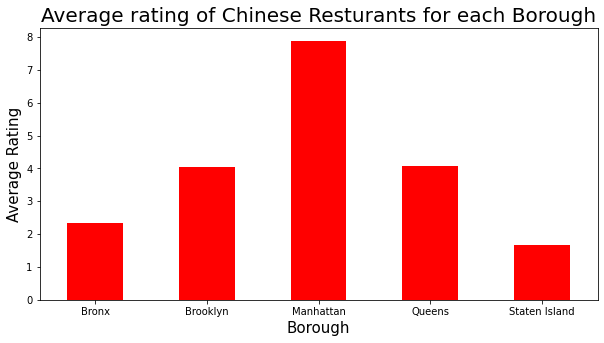

In [66]:
chn_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color='red')
plt.title('Average rating of Chinese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [67]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats
##due to the limited size of data, we drop the standard a tiny bit to be able to analysis more.

,Neighborhood,Average Rating
9,Boerum Hill,8.000000
13,Central Harlem,7.800000
14,Chelsea,8.800000
15,Chinatown,8.022222
19,College Point,8.100000
24,Downtown,8.300000
28,East Village,8.400000
31,Elmhurst,8.100000
36,Forest Hills,7.500000
42,Greenwich Village,8.450000


In [68]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,nyc_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.000000
1,Manhattan,Central Harlem,40.815976,-73.943211,7.800000
2,Manhattan,Chelsea,40.744035,-74.003116,8.800000
3,Staten Island,Chelsea,40.594726,-74.189560,8.800000
4,Manhattan,Chinatown,40.715618,-73.994279,8.022222
5,Queens,College Point,40.784903,-73.843045,8.100000
6,Brooklyn,Downtown,40.690844,-73.983463,8.300000
7,Manhattan,East Village,40.727847,-73.982226,8.400000
8,Queens,Elmhurst,40.744049,-73.881656,8.100000
9,Queens,Forest Hills,40.725264,-73.844475,7.500000


In [69]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


In [70]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = pd.read_csv('nybb.csv')
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')



In [ ]:

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')